In [21]:
# all imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from sklearn.utils import resample




In [22]:
# aka env variables
BASE_DIR = '/kaggle/input/airbus-ship-detection'
TEST_IMG_DIR = os.path.join(BASE_DIR,'test_v2')
TRAIN_IMG_DIR = os.path.join(BASE_DIR,'train_v2')
TRAIN_DATASET_CSV = os.path.join(BASE_DIR,'train_ship_segmentations_v2.csv')

########################################################################################

# print(TEST_IMG)
# print(TRAIN_IMG)
# print(TRAIN_DATASE_CSV)

In [23]:
# get train/test image list
train_imgs = os.listdir(TRAIN_IMG_DIR)
test_imgs = os.listdir(TEST_IMG_DIR)

# print(f"{train_imgs[:10]}")
# print(f"{test_imgs[:10]}")

In [24]:
# read dataset
df = pd.read_csv(TRAIN_DATASET_CSV)
df_backup = df

# add info about ship beeing present in the image
df['has_ship'] = df['EncodedPixels'].apply(lambda x: 0 if pd.isna(x) else 1)

# add info about total number of ships at the image
df['ship_count'] = df.groupby('ImageId')['EncodedPixels'].transform('count')

# concat all EncodedPixels into AllEncodedPixels
df['AllEncodedPixels'] = df.groupby('ImageId')['EncodedPixels'].transform(
    lambda x: np.nan if x.isna().all() else ' '.join(filter(None, x))
)

# remove repeating images
df = df.drop_duplicates(subset='ImageId', keep='first')

# delete EncodedPixels column
df = df.drop(columns=['EncodedPixels'])

# reset indexes
df = df.reset_index(drop=True)


df.head()


ImageId  has_ship  ship_count  \
0  00003e153.jpg         0           0   
1  0001124c7.jpg         0           0   
2  000155de5.jpg         1           1   
3  000194a2d.jpg         1           5   
4  0001b1832.jpg         0           0   

                                    AllEncodedPixels  
0                                                NaN  
1                                                NaN  
2  264661 17 265429 33 266197 33 266965 33 267733...  
3  360486 1 361252 4 362019 5 362785 8 363552 10 ...  
4                                                NaN

In [25]:
# check the results of the previous operations

tst = df[df['ImageId'] == '000194a2d.jpg']['AllEncodedPixels'].tolist()
print(tst)

['360486 1 361252 4 362019 5 362785 8 363552 10 364321 10 365090 9 365858 10 366627 10 367396 9 368165 9 368933 10 369702 10 370471 9 371240 9 372009 9 372777 10 373546 9 374315 9 375084 7 375852 6 376621 3 377390 1 51834 9 52602 9 53370 9 54138 9 54906 9 55674 7 56442 7 57210 7 57978 7 58746 7 59514 7 60282 7 61050 9 61818 9 62586 9 63354 9 64122 9 64890 9 198320 10 199088 10 199856 10 200624 10 201392 10 202160 10 202928 10 203696 10 204464 10 205232 10 206000 10 206768 10 207536 10 208304 10 209072 10 209840 10 210608 10 211376 10 212144 10 212912 10 213680 10 214448 10 215216 10 215984 10 216751 10 217519 10 218287 10 219055 10 219823 10 220591 10 221359 10 222127 10 222895 10 223663 10 224431 10 225199 10 225967 10 226735 10 227503 10 228271 10 229039 10 229807 10 230575 10 231343 10 232111 10 232879 10 233647 10 234415 10 55683 1 56451 1 57219 1 57987 1 58755 1 59523 1 60291 1 254389 9 255157 17 255925 17 256693 17 257461 17 258229 17 258997 17 259765 17 260533 17 261301 17 26206

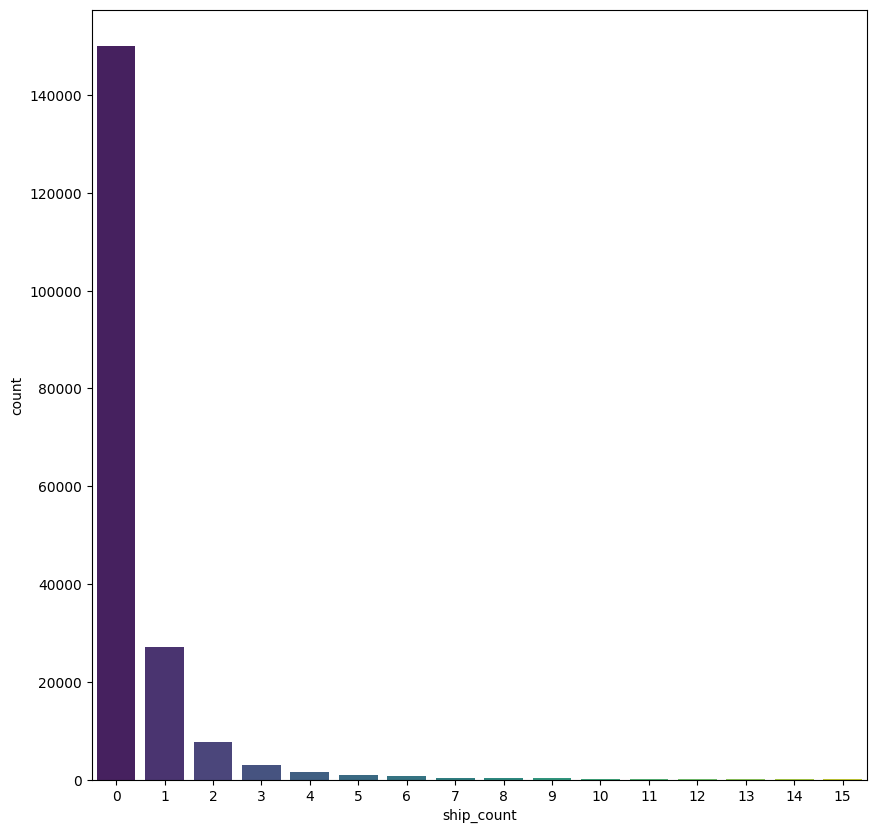

In [26]:
# check distribution of ship_count per image
plt.figure(figsize=(10,10))
sns.countplot(x='ship_count', data=df, palette='viridis')
plt.show()

In [27]:

value_counts = df['ship_count'].value_counts()
print(value_counts)


ship_count
0     150000
1      27104
2       7674
3       2954
4       1622
5        925
6        657
7        406
8        318
9        243
10       168
11       144
12       124
14        76
13        75
15        66
Name: count, dtype: int64


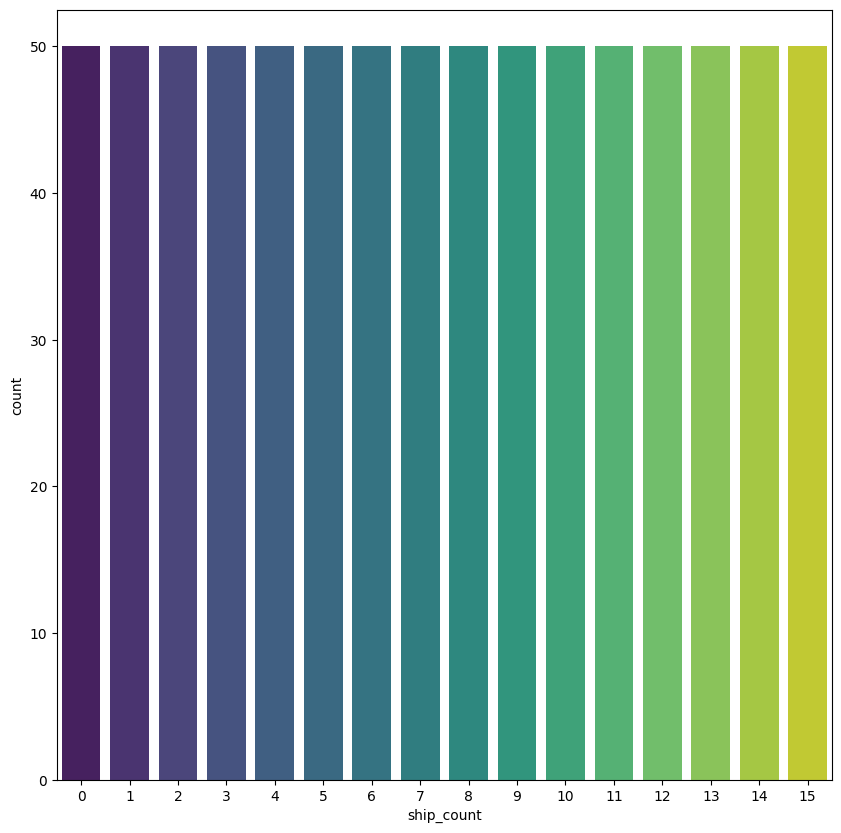

In [28]:
# balance dataset
NUM_SAMPLES = 50
# NUM_SAMPLES = value_counts.min()

balanced_df = pd.DataFrame()

for value in value_counts.index:
    subset = df[df['ship_count'] == value]
    number_samples = NUM_SAMPLES if NUM_SAMPLES < len(subset) else len(subset)
#     print(f"subset len - {len(subset)}")
    resampled_subset = resample(subset, replace=False, n_samples=number_samples, random_state=42)
    balanced_df = pd.concat([balanced_df, resampled_subset])

plt.figure(figsize=(10,10))
sns.countplot(x='ship_count', data=balanced_df, palette='viridis')
plt.show()


In [29]:
# split train data into train and validation
from sklearn.model_selection import train_test_split
train_ids, validation_ids = train_test_split(
    balanced_df, test_size = 0.2, stratify = balanced_df['ship_count'])

train_df = pd.merge(balanced_df, train_ids)
validation_df = pd.merge(balanced_df, validation_ids)

print(f"train_df:\n {train_df.sample(5)}")
print(f"validation_df:\n {validation_df.sample(5)}")

train_df:
            ImageId  has_ship  ship_count  \
282  37bab0556.jpg         1           7   
63   f9314d17f.jpg         1           1   
258  85c0e41be.jpg         1           6   
547  dd8ad9f2a.jpg         1          14   
481  625afd0eb.jpg         1          12   

                                      AllEncodedPixels  
282  308225 8 308993 8 309761 8 310529 8 311297 8 3...  
63   397313 1 398080 3 398847 5 399614 7 400381 9 4...  
258  220257 1 221024 3 221790 6 222557 7 223324 9 2...  
547  419278 2 420045 4 420812 7 421580 6 422347 6 4...  
481  367746 1 368512 4 369279 6 370048 5 370817 5 3...  
validation_df:
            ImageId  has_ship  ship_count  \
107  4830cb243.jpg         1          10   
88   870fc6316.jpg         1           8   
15   904cc459a.jpg         1           1   
108  2f4eb1f5f.jpg         1          10   
74   24a3eee13.jpg         1           7   

                                      AllEncodedPixels  
107  330905 9 331673 17 332441 17 333209 17 

In [30]:
#utility functions
def rle_to_mask(starts, lengths, height, width):
    # Create an empty array of zeros of shape (height, width)
    mask = np.zeros(height * width, dtype=np.uint8)
    
    # For each start and length, set the corresponding values in the mask to 1
    for start, length in zip(starts, lengths):
        mask[start:start + length] = 1
    
    # Reshape the mask into the desired dimensions
    mask = mask.reshape((height, width))
    mask = mask.T
    return mask

def create_mask(mask_array, width=768, height=768):
    masks = np.zeros((width, height), dtype=np.int16)
    # if element == element:
    if isinstance(mask_array, str):
        split = mask_array.split()
        # print(split)
        startP, lengthP = [np.array(x, dtype=int) for x in (split[::2], split[1::2])]
        masks += (rle_to_mask(startP, lengthP, width, height))
    return masks

In [31]:
# image generator
BATCH_SIZE = 4

def img_gen(input_df, batch_size = BATCH_SIZE):
    # shuffle the dataset
    input_df = input_df.sample(frac=1, random_state=42).reset_index(drop=True)
#     print(input_df.head())
    out_rgb = []
    out_mask = []
    i = 1
    while True:
        for index, row in input_df.iterrows():
            rgb_path = os.path.join(TRAIN_IMG_DIR, row.ImageId)
            rgb = Image.open(rgb_path)
            rgb = np.array(rgb)/255.0
            mask = create_mask(row.AllEncodedPixels)
            mask = np.expand_dims(mask, -1)
#             print(f"mask shape {mask.shape}")
#             print(f"rgb shape {rgb.shape}")
            out_rgb += [rgb]
            out_mask += [mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0), np.stack(out_mask, 0).astype(np.float32)
                out_rgb, out_mask=[], []

# for index, row in df.iterrows():
# img_gen(train_df)

In [32]:
train_gen = img_gen(train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (4, 768, 768, 3) 0.0 1.0
y (4, 768, 768, 1) 0.0 1.0


In [33]:
# create validation set
VALIDATION_SET_SIZE = 25

validation_x, validation_y = next(img_gen(validation_df, VALIDATION_SET_SIZE))

In [34]:
# data augmentation
# TODO